# Notebook for catboost model development and testing

scores: 
- 173 med objective="MultiRSME", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"
- 171 med objective="MAE", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"


## Getting data

trying 
- observed data as our training data
- estimated data as our validation data
- estimated testing as our test data 

In [13]:
%store -r dm 

from sklearn.model_selection import train_test_split

dm = dm

X_A_train = dm.data_A_obs.iloc[:, 2:-1]
y_A_train = dm.data_A_obs.iloc[:,0]
X_B_train = dm.data_B_obs.iloc[:, 2:-1]
y_B_train = dm.data_B_obs.iloc[:,0]
X_C_train = dm.data_C_obs.iloc[:, 2:-1]
y_C_train = dm.data_C_obs.iloc[:,0]

X_A_val = dm.data_A_es.iloc[:, 2:-1]
y_A_val = dm.data_A_es.iloc[:,0]
X_B_val = dm.data_B_es.iloc[:, 2:-1]
y_B_val = dm.data_B_es.iloc[:,0]


X_C_val = dm.data_C_es.iloc[:, 2:-1]
y_C_val = dm.data_C_es.iloc[:,0]

print(X_C_train.shape, y_C_train.shape)

X_A_test = dm.X_test_estimated_a[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]
X_B_test = dm.X_test_estimated_b[dm.X_test_estimated_b.columns.intersection(X_B_train.columns)]
X_C_test = dm.X_test_estimated_c[dm.X_test_estimated_c.columns.intersection(X_C_train.columns)]



X_A_test.shape

(93177, 25) (93177,)


(720, 25)

In [19]:
from catboost import CatBoostRegressor

catModel_A = CatBoostRegressor(objective="MAE", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS")
catModel_B = CatBoostRegressor(objective="MAE", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS")
catModel_C = CatBoostRegressor(objective="MAE", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS")

catModel = CatBoostRegressor()

In [20]:
catModel_A.fit(X_A_train, y_A_train)
catModel_B.fit(X_B_train, y_B_train)
catModel_C.fit(X_C_train, y_C_train)

0:	learn: 615.4782433	total: 65.4ms	remaining: 1m 5s
1:	learn: 567.3027248	total: 78.5ms	remaining: 39.1s
2:	learn: 541.4944941	total: 86.9ms	remaining: 28.9s
3:	learn: 497.2534626	total: 131ms	remaining: 32.7s
4:	learn: 463.5233320	total: 140ms	remaining: 27.9s
5:	learn: 463.1493533	total: 145ms	remaining: 24s
6:	learn: 462.8247922	total: 151ms	remaining: 21.4s
7:	learn: 427.3272181	total: 221ms	remaining: 27.4s
8:	learn: 400.0676846	total: 231ms	remaining: 25.4s
9:	learn: 375.2311925	total: 243ms	remaining: 24s
10:	learn: 352.9658888	total: 267ms	remaining: 24s
11:	learn: 352.7295067	total: 273ms	remaining: 22.5s
12:	learn: 346.6164749	total: 281ms	remaining: 21.3s
13:	learn: 328.2050005	total: 298ms	remaining: 21s
14:	learn: 322.5289351	total: 306ms	remaining: 20.1s
15:	learn: 322.3092600	total: 314ms	remaining: 19.3s
16:	learn: 322.1150905	total: 323ms	remaining: 18.7s
17:	learn: 321.9828667	total: 330ms	remaining: 18s
18:	learn: 312.3706978	total: 341ms	remaining: 17.6s
19:	learn:

In [21]:
score_A = catModel_A.score(X_A_val, y_A_val)
score_B = catModel_B.score(X_B_val, y_B_val)
score_C = catModel_C.score(X_C_val, y_C_val)

print(score_A)
print(score_B)
print(score_C)


0.8706907670373453
0.7755742692917549
0.7508848772174368


<AxesSubplot: >

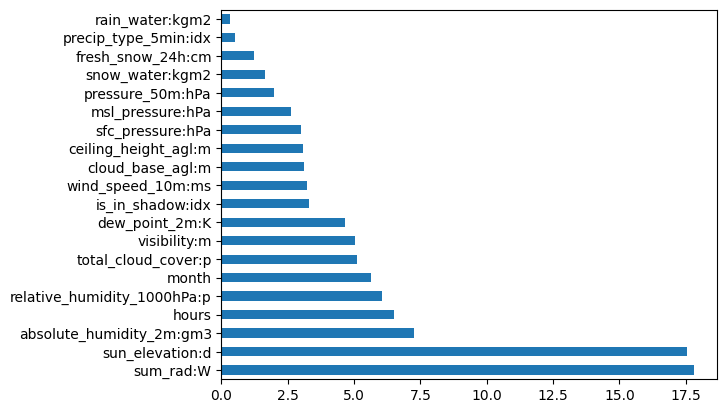

In [26]:
import pandas as pd

(pd.Series(catModel_C.feature_importances_, index=X_A_test.columns)
   .nlargest(20)
   .plot(kind='barh')) 

In [24]:
## Specify the model to be used
pred_A = catModel_A.predict(X_A_test)
pred_B = catModel_B.predict(X_B_test)
pred_C = catModel_C.predict(X_C_test)

## drit i å forstå, det funker 
test = pd.read_csv('test.csv')

df_A = pd.DataFrame()

df_A["prediction"] = pred_A
df_A["location"] = "A"

df_B = pd.DataFrame()

df_B["prediction"] = pred_B
df_B["location"] = "B"

df_C = pd.DataFrame()

df_C["prediction"] = pred_C
df_C["location"] = "C"

df_mid = pd.concat([df_A, df_B], ignore_index=True)

df = pd.concat([df_mid, df_C], join="inner", ignore_index=True)

df_C['prediction'] = df_C['prediction'].astype(float)

test = test[test.columns.intersection(["id", "time", "location"])]

df = df.drop("location", axis=1)

df.set_index(test["id"])
# df["id"] = test["id"]

# df = df[["id", "prediction"]]

df[df < 0 ] = 0

# NAME THE FILE 
df.to_csv("sub26.csv")

df


,prediction
0,0.000000
1,0.000000
2,0.000000
3,143.732626
4,472.379338
...,...
2155,26.551922
2156,17.030732
2157,2.848068
2158,3.161430
